In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.ticker import FuncFormatter

In [146]:
def avl_data_cleaning(avl_data):
    avl_data.columns = ['IMEI', 'start_time', 'stop_time', 'distance_travelled', 'moving_time', 'idle_time', 'max_speed']
    columns_to_check = ['distance_travelled', 'moving_time', 'idle_time', 'max_speed']
    avl_data = avl_data[~(avl_data[columns_to_check] == 0).all(axis=1)] # Remove rows where all specified columns are zero
    # Keeps rows where distance_travelled is not zero or only idel_time is not zero
    avl_data = avl_data[
    ~((avl_data['distance_travelled'] == 0) & 
      ((avl_data['idle_time'] == 0) | 
       (avl_data['max_speed'] != 0) | 
       (avl_data['moving_time'] != 0)))
    ]
    # Remove rows where distance_travelled is not zero but speed and moving_time are both zero
    avl_data = avl_data[
        ~((avl_data['distance_travelled'] != 0) & 
          (avl_data['max_speed'] == 0) & 
          (avl_data['moving_time'] == 0))
    ]
    # Revise trip start year by rolling over the second half of the year to the next year
    avl_data['start_time'] = pd.to_datetime(avl_data['start_time'].astype(str), format='%Y%m%d%H%M%S')
    avl_data['trip_start_year'] = avl_data['start_time'].dt.year
    # avl_data['trip_start_year'] = avl_data.apply(lambda row: row['trip_start_year'] + 1 if row['start_time'].month > 6 else row['trip_start_year'], axis=1)
    avl_data['trip_start_date'] = avl_data['start_time'].dt.date
    avl_data_w_idle = avl_data.copy()

    # Get the data with idle time greater than 0 and other three columns equal to 0
    idle_data = avl_data[(avl_data['idle_time'] > 0) & 
                         (avl_data['distance_travelled'] == 0) & 
                         (avl_data['moving_time'] == 0) & 
                         (avl_data['max_speed'] == 0)]
    # Filter out the idle data from the main dataframe
    avl_data_wt_idle = avl_data[~avl_data.index.isin(idle_data.index)]

    return avl_data_w_idle, avl_data_wt_idle


def merge_fleet_avl(avl_data, fleet_data):
    avl_data['IMEI'] = avl_data['IMEI'].astype(str).str.strip()
    merge_df = pd.merge(avl_data, fleet_data, on='IMEI', how='inner')
    columns_to_remove = ['Activity Type', 'Activity Type Description', 'Date Actual Retire', 'Actual Replacement date', \
                          'Today', 'num_days']
    merge_df = merge_df.drop(columns=columns_to_remove, errors='ignore')
    merge_df = merge_df[merge_df['trip_start_year'] >= merge_df['Start Service Year']]
    
    return merge_df


def agg_vkt(df):
    # Aggregate VKT by vehicle type, fuel type, start service year, trip start year, and IMEI
    # Also count the number of days by each by vehicle type, fuel type, start service year, trip start year, and IMEI
    # Calculate vkt per year by dividing the total vkt by the number of days
    agg_df = df.groupby(['Vehicle Type', 'Fuel Type', 'Start Service Year', 'trip_start_year', 'IMEI']).agg(
        actual_vkt=('distance_travelled', 'sum'),
        num_days=('trip_start_date', 'nunique')
    ).reset_index()
    agg_df.to_excel('../../results/new_results/1.xlsx')
    agg_df['vkt_per_year'] = agg_df['actual_vkt']
    agg_df = agg_df.sort_values(by=['Vehicle Type', 'Fuel Type', 'Start Service Year', 'trip_start_year', 'IMEI'])
    # Aggregate again to get the average vkt per year by vehicle type, fuel type, start service year, and trip start year
    agg_df = agg_df.groupby(['Vehicle Type', 'Fuel Type', 'Start Service Year', 'trip_start_year']).agg(
        annual_vkt_per_vehicle=('vkt_per_year', 'mean'),
        num_vehicles=('IMEI', 'nunique')
    ).reset_index()
    agg_df = agg_df.sort_values(by=['Vehicle Type', 'Fuel Type', 'Start Service Year', 'trip_start_year'])
    agg_df.to_excel('../../results/new_results/2.xlsx')
    # agg_df['Vehicle Age'] = agg_df['trip_start_year'] - agg_df['Start Service Year']
    # agg_df.to_excel('../../results/new_results/vkt_age_ratio_patterns.xlsx')
    
    # # AVL has trips earlier than start service year, filter out those trips
    # agg_df = agg_df[agg_df['trip_start_year'] >= agg_df['Start Service Year']]

    # Pivot the dataframe to have trip start year as columns, fill missing values with 0
    agg_df_vkt_pivot = agg_df.pivot_table(index=['Vehicle Type', 'Fuel Type', 'Start Service Year'], 
                                 columns='trip_start_year',
                                 values='annual_vkt_per_vehicle',
                                 fill_value=0).reset_index()
    agg_df_num_vehicles_pivot = agg_df.pivot_table(index=['Vehicle Type', 'Fuel Type', 'Start Service Year'], 
                                 columns='trip_start_year',
                                 values='num_vehicles',
                                 fill_value=0).reset_index()
    # agg_df_num_vehicles_pivot.to_excel('../../results/new_results/agg_df_num_vehicles_pivot.xlsx')
    # agg_df_vkt_pivot.to_excel('../../results/new_results/agg_df_vkt_pivot.xlsx')
    # Calculate the weighted average VKT per year for each vehicle type, fuel type, and trip start year, and store it in a new dataframe
    # Sumproduct of annual_vkt_per_vehicle and num_vehicles, then divide by the total number of vehicles
    # Use the above two pivot tables to calculate the weighted average VKT per year
    # Loop through each year column (skip the first 3: Vehicle Type, Fuel Type, trip_start_year)
    weighted_avg_vkt_pivot = agg_df_vkt_pivot.copy()
    for year in agg_df_vkt_pivot.columns[3:]:
        weighted_avg_vkt_pivot[year] = agg_df_vkt_pivot[year] * agg_df_num_vehicles_pivot[year]

    # Then group by vehicle and fuel type divided by sum of num_vehicles to get weighted average
    weighted_avg_vkt_pivot = weighted_avg_vkt_pivot.groupby(['Vehicle Type', 'Fuel Type']).sum().reset_index()
    weighted_avg_vkt_pivot = weighted_avg_vkt_pivot.drop(columns=['Start Service Year'])
    num_vehicles_pivot = agg_df_num_vehicles_pivot.groupby(['Vehicle Type', 'Fuel Type']).sum().reset_index()
    num_vehicles_pivot = num_vehicles_pivot.drop(columns=['Start Service Year'])
    # Get vehicle number weighted average VKT per year
    for year in weighted_avg_vkt_pivot.columns[2:]:
        weighted_avg_vkt_pivot[year] = weighted_avg_vkt_pivot[year] / num_vehicles_pivot[year] / 1000  # Divide by 1000 to convert to thousands of km
    
    return weighted_avg_vkt_pivot


def vkt_distribution(df):
    def sci_formatter(x, pos):
        return f"$10^{{{int(x)}}}$" if x >= 1 else ""
    
    agg_df = df.groupby(['Vehicle Type', 'Fuel Type', 'IMEI']).agg(
        actual_vkt=('distance_travelled', 'sum'),
        num_days=('trip_start_date', 'nunique')
    ).reset_index()

    agg_df['vkt_per_year'] = agg_df['actual_vkt'] / agg_df['num_days'] * 365
    agg_df = agg_df.sort_values(by=['Vehicle Type', 'Fuel Type', 'IMEI'])

    vehicle_classes = agg_df['Vehicle Type'].unique().tolist()
    n = len(vehicle_classes)

    # Remove inf and NaN from 'Total VKT'
    agg_df = agg_df.replace([np.inf, -np.inf], np.nan)
    agg_df = agg_df.dropna(subset=['vkt_per_year'])

    # Set up subplots: 1 column, n rows
    ncols = 1
    nrows = n
    fig, axes = plt.subplots(nrows, ncols, figsize=(8, 4*nrows), squeeze=False)
    palette = sns.color_palette("tab10", n)

    for i, vehicle_cls in enumerate(vehicle_classes):
        ax = axes[i, 0]

        # vkt = df[df['Vehicle Type'] == vehicle_cls]['Total VKT']  # Both Gasoline and Diesel
        vkt = agg_df[(agg_df['Vehicle Type'] == vehicle_cls) & (agg_df['Fuel Type'] == 'Gasoline')]['vkt_per_year']  # Gasoline only
        if len(vkt) == 0:
            ax.axis('off')
            continue

        log_vkt = np.log10(vkt.values)
        mean_vkt = np.mean(vkt.values)

        # Plot histogram and capture bar heights
        hist_data = sns.histplot(log_vkt, stat='percent', kde=False, bins=30,
                                 alpha=0.6, color=palette[i], ax=ax, linewidth=0)
        
        # Get histogram peak height
        bar_heights = [bar.get_height() for bar in hist_data.patches]
        max_bar_height = max(bar_heights) if bar_heights else 1

        # Plot KDE
        kde_plot = sns.kdeplot(log_vkt, ax=ax, color=palette[i], linewidth=2)
        line = kde_plot.get_lines()[-1]
        y_kde = line.get_ydata()
        max_kde_height = y_kde.max() if len(y_kde) > 0 else 1

        # Scale KDE to match histogram peak
        scale_factor = max_bar_height / max_kde_height
        line.set_ydata(y_kde * scale_factor)

        # Add mean VKT label
        ax.text(0.95, 0.90,
                f"Mean VKT: {mean_vkt:,.0f} km",
                transform=ax.transAxes,
                ha='right', va='top',
                fontsize=18, color='black')

        ax.xaxis.set_major_formatter(FuncFormatter(sci_formatter))
        ax.set_xlabel('Total VKT (km)', fontsize=18)
        ax.set_ylabel('Percent (%)', fontsize=18)
        ax.set_title(f'VKT Distribution: {vehicle_cls}', fontsize=20)
        ax.tick_params(axis='both', labelsize=14)

    plt.tight_layout()
    plt.show()

    

In [ ]:
avl_data_df = pd.read_csv('../../data/avl_data/RND.csv')
avl_data_w_idle, avl_data_wt_idle = avl_data_cleaning(avl_data_df)

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_2103/2546759928.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  avl_data_df = pd.read_csv('../../data/avl_data/RND.csv')


In [135]:
fleet_data_df = pd.read_excel('../../results/new_results/fleet_merged_df_wt_rollover.xlsx')

In [ ]:
fleet_data_df = fleet_data_df.dropna(subset=['IMEI'])
avl_data_w_idle = avl_data_w_idle.dropna(subset=['IMEI'])
merged_df = merge_fleet_avl(avl_data_w_idle, fleet_data_df)
merged_df.shape

(25176, 20)
(25174, 20)


In [122]:
imei_avl = set(avl_data_w_idle['IMEI'].unique())
imei_fleet = set(fleet_data_df['IMEI'].unique())

# In avl_data_w_idle but not in fleet_data_df
only_in_avl = imei_avl - imei_fleet
print("Count only in AVL:", len(only_in_avl))

only_in_fleet = imei_fleet - imei_avl
print("Count only in Fleet Data:", len(only_in_fleet))

# Count in both
in_both = imei_avl & imei_fleet
print("Count in both AVL and Fleet Data:", len(in_both))

print(len(only_in_avl) - len(only_in_fleet))

Count only in AVL: 4457
Count only in Fleet Data: 1367
Count in both AVL and Fleet Data: 19632
3090


In [62]:
print(len(set(fleet_data_df['IMEI'].unique())), len(set(avl_data_w_idle['IMEI'].unique())))
vehicle_counts = merged_df.groupby('Vehicle Type')['IMEI'].nunique()
print(vehicle_counts)

20999 24089
Vehicle Type
Light-duty truck     6248
Medium-duty truck    1701
SUV                  5610
Security Patrol       569
Sedan                5991
Name: IMEI, dtype: int64


In [145]:
merged_df.head()

,IMEI,start_time,stop_time,distance_travelled,moving_time,idle_time,max_speed,trip_start_year,trip_start_date,Primary Status,...,Model,Model Year,Date Accepted,Current Odometer Reading,Vehicle Type,Fuel Type,Start Service Year,Retire date filled,service year,Total VKT
0,355200041445104,2013-07-09 11:22:25,20130709164325,15.0,1218,977,67,2013,2013-07-09,Retired,...,Land Cruiser,2013,2013-10-29,157001.0,SUV,Gasoline,2013,2020-09-13,6.9,22822.0
1,355200041445104,2013-07-10 06:57:13,20130710132902,10.0,1339,198,63,2013,2013-07-10,Retired,...,Land Cruiser,2013,2013-10-29,157001.0,SUV,Gasoline,2013,2020-09-13,6.9,22822.0
2,355200041445104,2013-07-11 06:52:38,20130711142330,41.0,3899,882,83,2013,2013-07-11,Retired,...,Land Cruiser,2013,2013-10-29,157001.0,SUV,Gasoline,2013,2020-09-13,6.9,22822.0
3,355200041445104,2013-07-14 06:55:57,20130714151747,32.0,2557,693,103,2013,2013-07-14,Retired,...,Land Cruiser,2013,2013-10-29,157001.0,SUV,Gasoline,2013,2020-09-13,6.9,22822.0
4,355200041445104,2013-07-15 06:51:43,20130715130206,8.0,704,134,67,2013,2013-07-15,Retired,...,Land Cruiser,2013,2013-10-29,157001.0,SUV,Gasoline,2013,2020-09-13,6.9,22822.0


In [64]:
# compare total vkt per vehicle from AVL with ODO reading
actual_miles = merged_df.groupby('IMEI').agg(
    actual_lifetime_vkt = ('distance_travelled', 'sum'),
    odo_reading = ('Current Odometer Reading', 'first')).reset_index()
actual_miles.head()

,IMEI,actual_lifetime_vkt,odo_reading
0,352439092237665,105647.0,106701.0
1,352736062249694,241722.0,250263.0
2,352739090050771,206592.0,222041.0
3,352739090051225,70565.0,79285.0
4,352739090051324,55629.0,61041.0


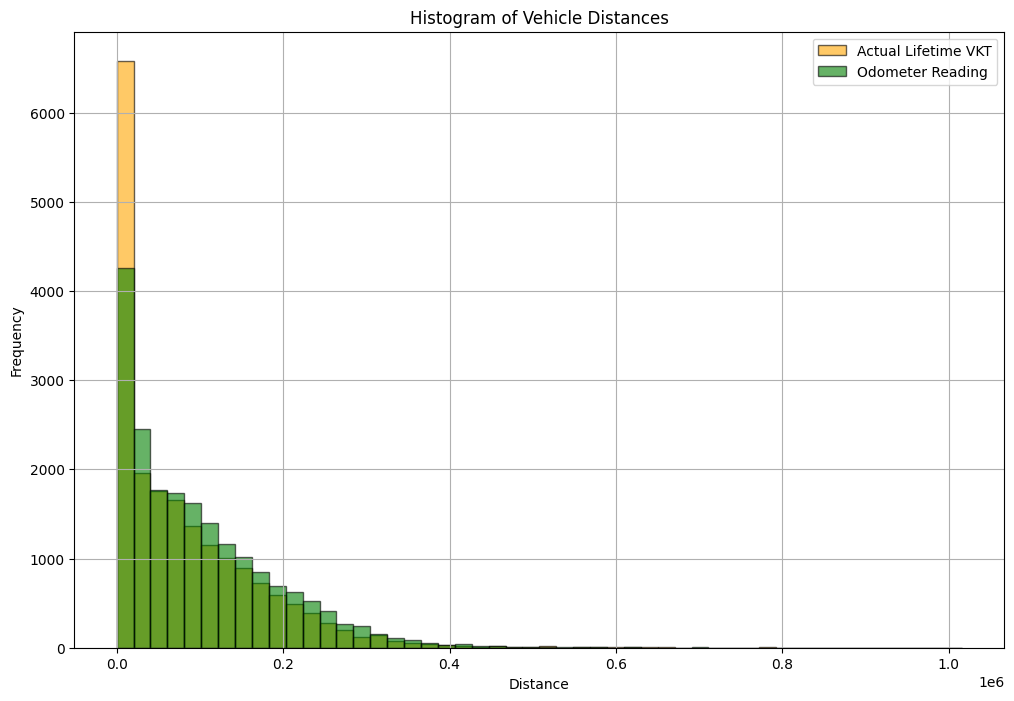

In [65]:
vkt = actual_miles['actual_lifetime_vkt'].dropna()
odo = actual_miles['odo_reading'].dropna()

# Combine clean data to compute common bin edges
combined_data = np.concatenate([vkt, odo])
bin_edges = np.histogram_bin_edges(combined_data, bins=50)

plt.figure(figsize=(12, 8))
plt.hist(vkt, bins=bin_edges, color='orange', alpha=0.6, label='Actual Lifetime VKT', edgecolor='black')
plt.hist(odo, bins=bin_edges, color='green', alpha=0.6, label='Odometer Reading', edgecolor='black')

plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Vehicle Distances')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
actual_miles_by_year = merged_df.groupby(['Vehicle Type', 'trip_start_year']).agg(
    actual_lifetime_vkt = ('distance_travelled', 'sum')).reset_index()
actual_miles_by_year.to_excel('../../results/new_results/actual_miles_by_year.xlsx')

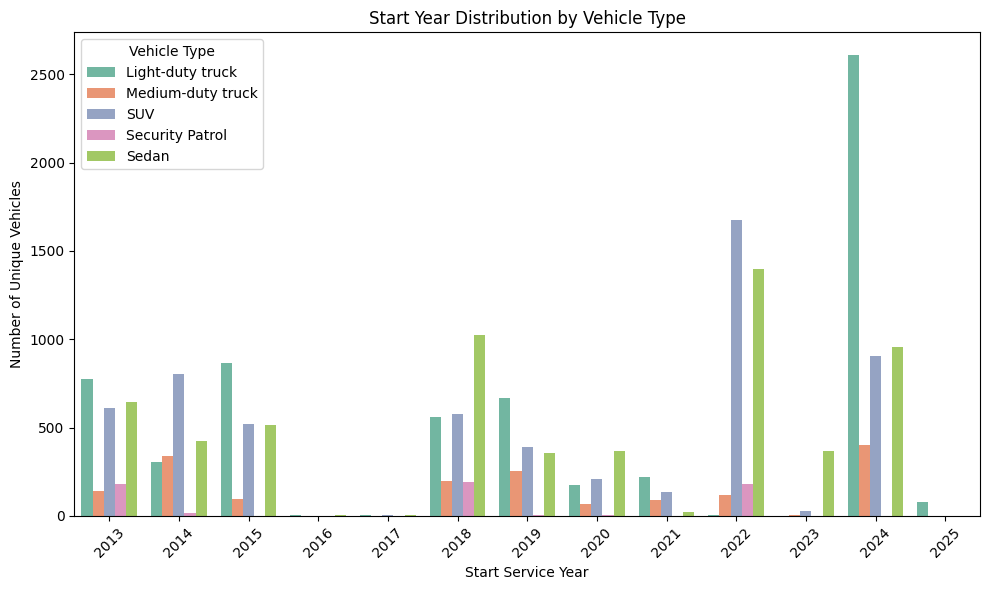

In [66]:
# Plot start year distribution for each vehicle type
grouped_df = merged_df.groupby(['Start Service Year', 'Vehicle Type'])['IMEI'].nunique().reset_index()
grouped_df.rename(columns={'IMEI': 'num_vehicles'}, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_df, x='Start Service Year', y='num_vehicles', hue='Vehicle Type', palette='Set2')
plt.xlabel('Start Service Year')
plt.ylabel('Number of Unique Vehicles')
plt.title('Start Year Distribution by Vehicle Type')
plt.xticks(rotation=45)
plt.legend(title='Vehicle Type')
plt.tight_layout()
plt.show()


In [113]:
grouped_df.to_excel('../../results/new_results/avl_fleet_merge_vehicle_start_year_distribution.xlsx', index=False)

In [147]:
weighted_vkt = agg_vkt(merged_df)

In [76]:
weighted_vkt.shape

(111385, 9)

In [68]:
weighted_vkt.to_excel('../../results/new_results/weighted_avg_vkt_pivot_wt_rollover.xlsx', index=False)

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_2900/509726402.py:131: RuntimeWarning: divide by zero encountered in log10
  log_vkt = np.log10(vkt.values)
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_2900/509726402.py:131: RuntimeWarning: divide by zero encountered in log10
  log_vkt = np.log10(vkt.values)
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_2900/509726402.py:131: RuntimeWarning: divide by zero encountered in log10
  log_vkt = np.log10(vkt.values)
/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_2900/509726402.py:131: RuntimeWarning: divide by zero encountered in log10
  log_vkt = np.log10(vkt.values)


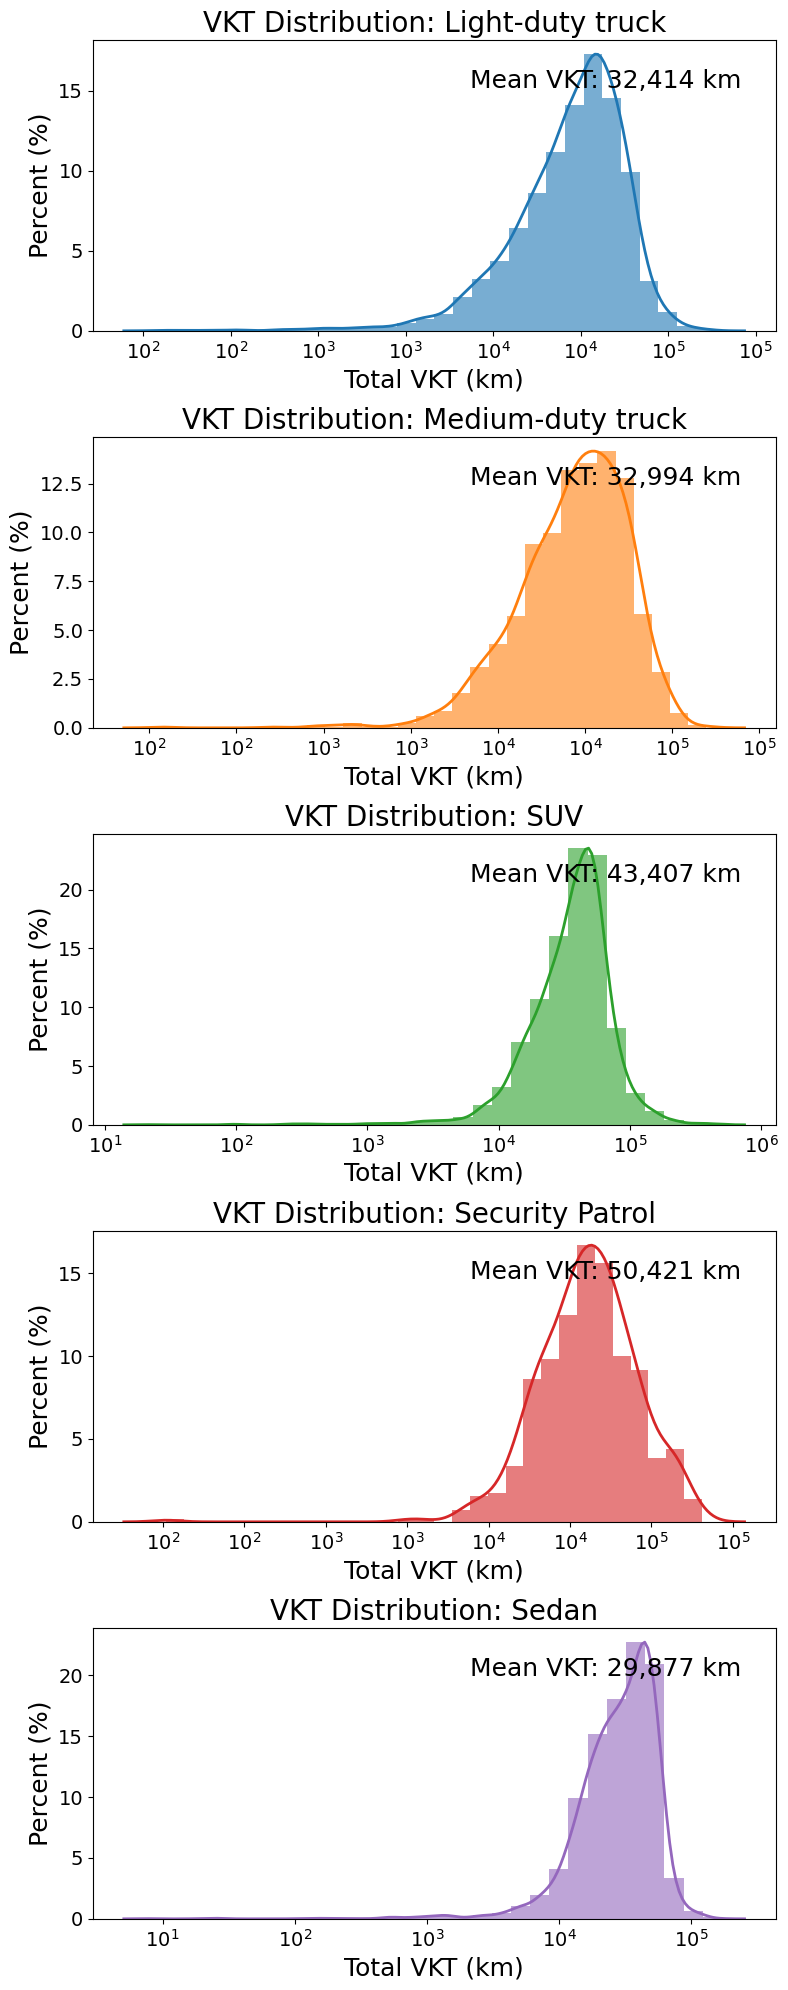

In [33]:
vkt_distribution(merged_df)

In [141]:
# Calculate real fleet size based on raw fleet data
fleet_size = {}
vehicle_types = fleet_data_df['Vehicle Type'].unique()
model_years = list(range(2008, 2025))
fleet_data_df = fleet_data_df[fleet_data_df['Fuel Type']=='Gasoline']

for veh_type in vehicle_types:
    for year in model_years:
        count_new_sale = len(fleet_data_df[(fleet_data_df['Vehicle Type'] == veh_type) &
                                  (fleet_data_df['Date Accepted'].dt.year <= year)])
        count_retired = len(fleet_data_df[(fleet_data_df['Vehicle Type'] == veh_type) &
                                  (fleet_data_df['Retire date filled'].dt.year <= year)])
        fleet_size[(veh_type, year)] = round((count_new_sale - count_retired)/1000, 2)

fleet_size_list = [
    {'Vehicle Type': vt, 'Year': yr, 'Fleet Size': size}
    for (vt, yr), size in fleet_size.items()
]

fleet_size_df = pd.DataFrame(fleet_size_list)
fleet_size_df.head()

,Vehicle Type,Year,Fleet Size
0,SUV,2008,0.15
1,SUV,2009,0.25
2,SUV,2010,0.32
3,SUV,2011,0.50
4,SUV,2012,0.48


In [142]:
fleet_size_df.to_excel('../../results/new_results/real_fleet_size_by_year_1.xlsx')

In [143]:
fleet_data_df.shape

(24818, 20)